In [1]:
!pip install transformers
!pip install sentencepiece
!pip install emoji

     |████████████████████████████████| 2.5MB 14.5MB/s 
     |████████████████████████████████| 901kB 51.5MB/s 
     |████████████████████████████████| 3.3MB 48.4MB/s 
     |████████████████████████████████| 1.2MB 15.1MB/s 
     |████████████████████████████████| 133kB 15.0MB/s 


In [4]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#checking python version
!python --version

Python 3.7.10


In [6]:
#importing necessary files

#for model building 
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import json
import gc
from sklearn.model_selection import train_test_split

#for EDA
import pandas as pd
import numpy as np
import os
import math
import torch
from time import time
import re
import string
import emoji
from pprint import pprint
import collections
import seaborn as sns
import matplotlib.pyplot as plt
#cleaning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


In [7]:
print(tf.__version__)

2.5.0


##Dataset

In [8]:
#changing the column names as per convenience
col_names=['category','B','text']
#loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Data/Case3_Dataset.csv',names=col_names,header=None)
df.head()

,category,B,text
0,airline_sentiment,airline,text
1,neutral,Virgin America,@VirginAmerica What @dhepburn said.
2,positive,Virgin America,@VirginAmerica plus you've added commercials t...
3,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
4,negative,Virgin America,@VirginAmerica it's really aggressive to blast...


In [9]:
#column 'B' is of no use so dropping it
df=df.drop('B',axis=1)
df = df.iloc[1: , :]

In [10]:
#giving labels to the sentiments: 0->neutral, 1->positive, 2->negative
possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

df['label'] = df.category.replace(label_dict)
df.head()

,category,text,label
1,neutral,@VirginAmerica What @dhepburn said.,0
2,positive,@VirginAmerica plus you've added commercials t...,1
3,neutral,@VirginAmerica I didn't today... Must mean I n...,0
4,negative,@VirginAmerica it's really aggressive to blast...,2
5,negative,@VirginAmerica and it's a really big bad thing...,2


##EDA

In [11]:
#checking the number of datapoints for each sentiment class
df['category'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: category, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


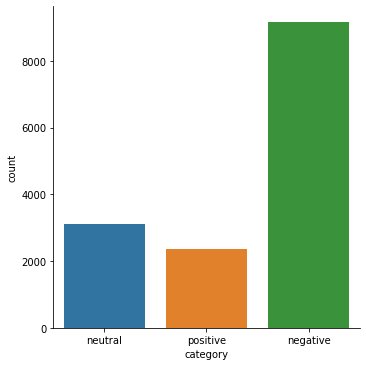

In [12]:
#plotting the count of different categories we have in out dataset
sns.factorplot(x="category", data=df, kind="count", size=5)
plt.show();

#it is an imbalanced dataset with a lot of negative sentiments

In [13]:
Y=df['label']
X=df

In [14]:
#seeing the insights of the text we have 
total_words=0
total_at_rate=0
total_hashtag=0
total_capital_words=0
total_excl_ques=0

for i in range(1,len(X['text'])+1):
  total_words = total_words+ len(re.findall(r'\w+', X['text'][i]))
  total_at_rate = total_at_rate+ len(re.findall(r'@\w+', X['text'][i]))
  total_hashtag = total_hashtag+ len(re.findall(r'#\w+', X['text'][i]))
  total_capital_words = total_capital_words+len(re.findall(r'\b[A-Z]{2,}\b', X['text'][i]))  
  total_excl_ques = total_excl_ques+ len(re.findall(r'!|\?', X['text'][i]))

print(total_words)
print(total_at_rate)
print(total_hashtag)
print(total_capital_words)
print(total_excl_ques)

268713
16507
3502
6460
9990


In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
#cleaning the data
class CleanText(BaseEstimator, TransformerMixin):
    def rem_at(self, text):
        return re.sub(r'@\w+', '', text)
    
    def rem_hash(self, text):
        return re.sub(r'#\w+', '', text)

    def to_lower(self, text):
        return text.lower()

    def rem_punc(self, text):
        # Make translation table
        punct  = string.punctuation
        transtabl = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol is replaced by a space
        return text.translate(transtabl)
    
    def rem_digit(self, text):
        return re.sub('\d+', '', text)
    
    def stopwords(self, text):
        stopwords_list = stopwords.words('english')
        # words that are necessary to be kept
        avoid = ["n't", "not", "no"]
        #split sentence into words
        words = text.split() 
        #keep the word if it is not stopword or in avoid list
        clean_words = [word for word in words if (word not in stopwords_list or word in avoid) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, text):
      #PORTER STEMMER used here for stemming
        porter = PorterStemmer()
        #split sentence into words
        words = text.split()
        #apply stemming on words
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.rem_at).apply(self.rem_hash).apply(self.rem_punc).apply(self.to_lower).apply(self.rem_digit).apply(self.stopwords).apply(self.stemming)
        return clean_X

In [19]:
ct = CleanText()
X['eda_text'] = ct.fit_transform(X.text)
X.head()

,category,text,label,eda_text,eda_test
1,neutral,@VirginAmerica What @dhepburn said.,0,said,said
2,positive,@VirginAmerica plus you've added commercials t...,1,plu ad commerci experi tacki,plu ad commerci experi tacki
3,neutral,@VirginAmerica I didn't today... Must mean I n...,0,today must mean need take anoth trip,today must mean need take anoth trip
4,negative,@VirginAmerica it's really aggressive to blast...,2,realli aggress blast obnoxi entertain guest fa...,realli aggress blast obnoxi entertain guest fa...
5,negative,@VirginAmerica and it's a really big bad thing...,2,realli big bad thing,realli big bad thing


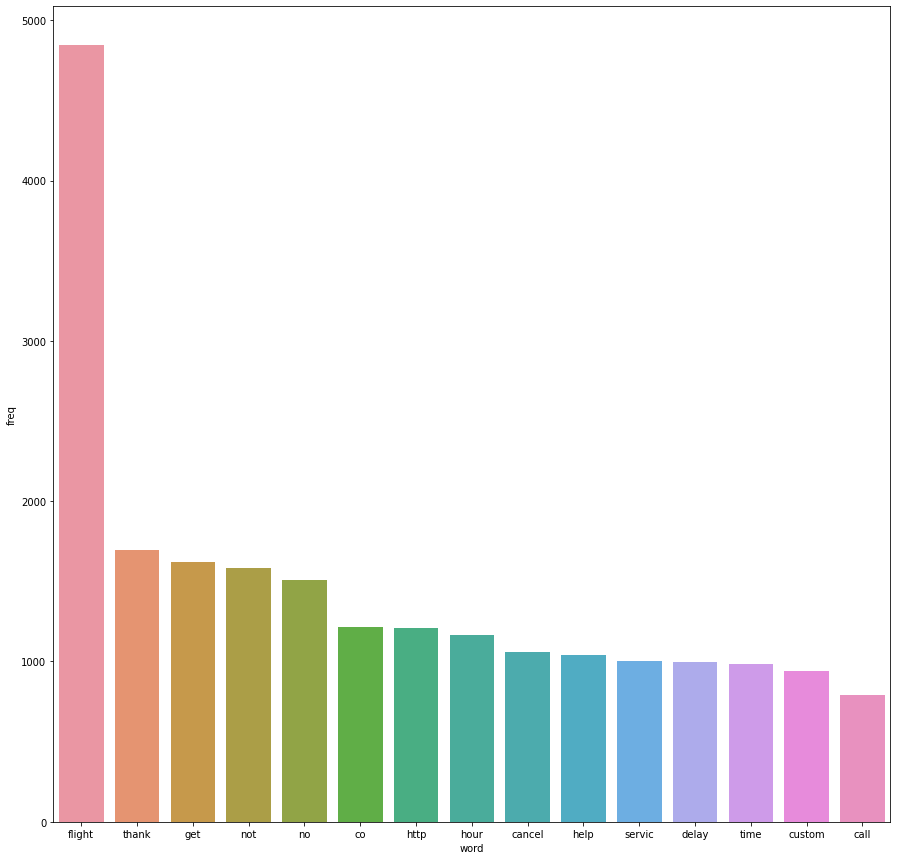

In [20]:
#15 most frequent words in out dataset are

#fir we need to vectorise out text data
cv = CountVectorizer()
#fit and transform the data
vec= cv.fit(X['eda_text'])
vec= cv.transform(X['eda_text'])
#extract the frequency of eaxch word
word_freq = dict(zip(cv.get_feature_names(), np.asarray(vec.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
#extract most max freq and corresponding word out of top 15 frequencies
word_counter_df = pd.DataFrame(word_counter.most_common(15), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(15, 15))
#plot the word vs freq graph using seaborn
sns.barplot(x="word", y="freq", data=word_counter_df, ax=ax)
plt.show();
#here we can see that flight is the most used word 

##Model

In [21]:
#converting text field and encoded_cat fields to lists
data_texts = df["eda_text"].to_list() 
data_labels = df["label"].to_list()

In [22]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data. Validation data size=20% and train_Data size=80% 
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)

# Keep some data for inference (testing). Test Data size=1%
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)

In [23]:
#initialsing tokenizer for DISTILBERT-BASE-UNCASED model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#encodings
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [24]:
#creating tensors of train and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [25]:
#initializing the DISTILBERT-BASE-UNCASED model from tensorflow library
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=151)

#initializing the optimizer as Adam with learning_rate as 5e^-5 for Finetuning
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

#compiling the model with respective optimizers and accuracy metric
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [26]:
#finetuning the model with batch size=16 and for 5 epochs
model.fit(train_dataset.shuffle(1000).batch(16), epochs=5, batch_size=16, validation_data=val_dataset.shuffle(1000).batch(16))

#we got final accuracy of 95% in training and 79% in validation set

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

##Saving 

In [27]:
#saving the finetuned model and tokenizer in Drive
save_directory = "/content/drive/MyDrive/Data" 

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/Data/tokenizer_config.json',
 '/content/drive/MyDrive/Data/special_tokens_map.json',
 '/content/drive/MyDrive/Data/vocab.txt',
 '/content/drive/MyDrive/Data/added_tokens.json')

In [28]:
#loading tokenizer from Drive for prediction
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
#loading the model from Drive for prediction
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /content/drive/MyDrive/Data were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Data and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Prediction

In [48]:
#testing by giving a random input text
test_text="contac eyewit news ripoff cancel flight want pay"
test_text

'contac eyewit news ripoff cancel flight want pay'

In [49]:
#prediction for the above text input
predict_input = loaded_tokenizer.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

#the output comes to be a list of length 3 with probabilities for each of the three classes negative,neutral,positive in order
#so we take the argmax of it so as to get the respective class
prediction_value = tf.argmax(output, axis=1).numpy()[0]


df.loc[df['label'] == prediction_value, 'category'].iloc[0]

#the context of the text above is positive

'negative'

##Prediction Accuracy

In [56]:
#Now Predicting for all the test data we have
pred_label=[]
for text in test_texts:
  predict_input = loaded_tokenizer.encode(text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

  output = loaded_model(predict_input)[0]

  #the output comes to be a list of length 3 with probabilities for each of the three classes negative,neutral,positive in order
  #so we take the argmax of it so as to get the respective class
  prediction_value = tf.argmax(output, axis=1).numpy()[0]
  pred_label.append(prediction_value)

In [62]:
#simply checking accuracy by seeing if predicted labels match the test labels
correct=0
for i in range(len(pred_label)):
  if pred_label[i]==test_labels[i]:
    correct+=1

#accuracy 
print(correct/len(pred_label))

0.8135593220338984
